In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Configuración de dispositivos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"device: {device}")

device: cuda


In [4]:
# Transformaciones de datos
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
# Carga de datos
train_dataset = ImageFolder('DatasetTumoresCerebrales/training', transform=data_transform)
test_dataset = ImageFolder('DatasetTumoresCerebrales/test', transform=data_transform)

In [6]:
# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

num_classes = len(train_dataset.classes)

In [7]:
test_dataset.classes

['Glioma', 'Meningioma', 'Pituitary tumor']

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Aplanar la salida para las capas completamente conectadas
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 10
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    correct_train = 0
    total_train = 0

    for i, data in enumerate(tqdm(train_loader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = torch.argmax(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracy_values.append(train_accuracy)

    model.eval()

    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracy_values.append(test_accuracy)

    print(f'Época {epoch + 1}, Pérdida: {running_loss / (i + 1):.4f}, Precisión (Entrenamiento): {train_accuracy:.2f}%, Precisión (Prueba): {test_accuracy:.2f}%')

100%|██████████| 87/87 [00:23<00:00,  3.74it/s]


Época 1, Pérdida: 0.6242, Precisión (Entrenamiento): 73.49%, Precisión (Prueba): 80.78%


100%|██████████| 87/87 [00:12<00:00,  6.87it/s]


Época 2, Pérdida: 0.3324, Precisión (Entrenamiento): 86.54%, Precisión (Prueba): 75.57%


100%|██████████| 87/87 [00:13<00:00,  6.40it/s]


Época 3, Pérdida: 0.2535, Precisión (Entrenamiento): 89.15%, Precisión (Prueba): 83.06%


100%|██████████| 87/87 [00:13<00:00,  6.33it/s]


Época 4, Pérdida: 0.1414, Precisión (Entrenamiento): 95.07%, Precisión (Prueba): 87.62%


100%|██████████| 87/87 [00:13<00:00,  6.37it/s]


Época 5, Pérdida: 0.1002, Precisión (Entrenamiento): 96.34%, Precisión (Prueba): 91.53%


100%|██████████| 87/87 [00:13<00:00,  6.42it/s]


Época 6, Pérdida: 0.0495, Precisión (Entrenamiento): 98.44%, Precisión (Prueba): 89.58%


100%|██████████| 87/87 [00:13<00:00,  6.42it/s]


Época 7, Pérdida: 0.0282, Precisión (Entrenamiento): 99.24%, Precisión (Prueba): 88.60%


100%|██████████| 87/87 [00:13<00:00,  6.34it/s]


Época 8, Pérdida: 0.0207, Precisión (Entrenamiento): 99.56%, Precisión (Prueba): 90.88%


100%|██████████| 87/87 [00:13<00:00,  6.47it/s]


Época 9, Pérdida: 0.0090, Precisión (Entrenamiento): 99.85%, Precisión (Prueba): 93.16%


100%|██████████| 87/87 [00:13<00:00,  6.33it/s]


Época 10, Pérdida: 0.0086, Precisión (Entrenamiento): 99.71%, Precisión (Prueba): 92.18%


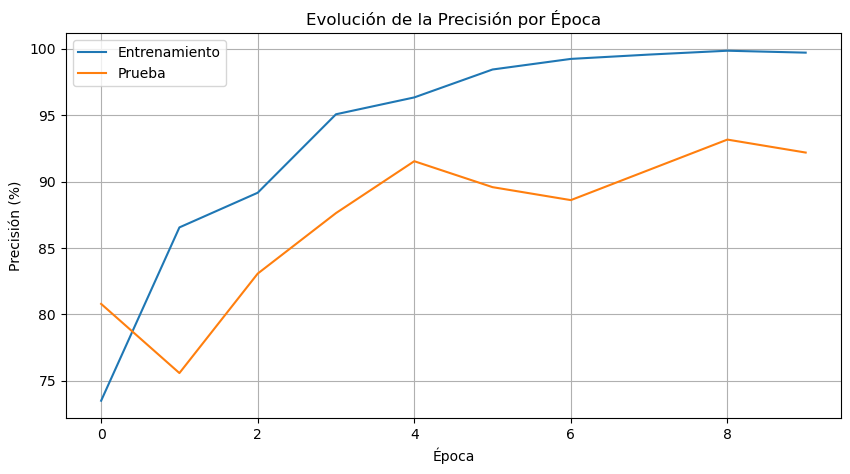

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_values, label='Entrenamiento')
plt.plot(test_accuracy_values, label='Prueba')
plt.title('Evolución de la Precisión por Época')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
torch.save(model.state_dict(), 'modelo_entrenado.pth')